# Setup

In [239]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter_11"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models", CHAPTER_ID)
LOGS_PATH = os.path.join(PROJECT_ROOT_DIR, "logs", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [56]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 11.1 勾配消失/爆発問題

In [57]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


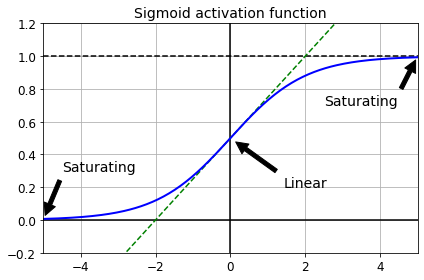

In [58]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## 11.1.1 GlorotとHeの初期値

In [59]:
# 初期化方法
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [60]:
# kernel_initializerで指定する
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [61]:
# VarianceScalingで亜種も使える
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 11.1.2 飽和しない活性化関数

In [62]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

In [63]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [64]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [65]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure leaky_relu_plot


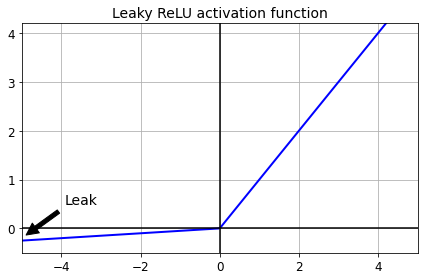

In [66]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Saving figure elu_plot


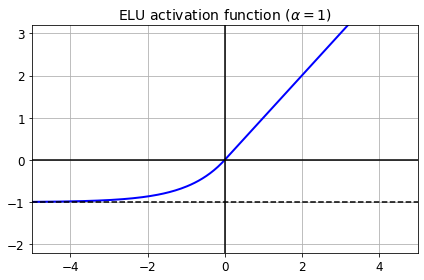

In [67]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Saving figure selu_plot


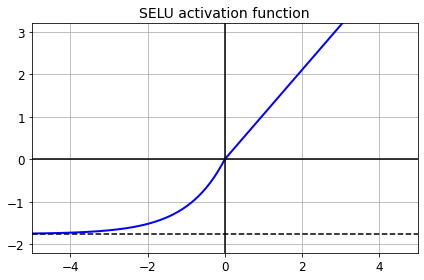

In [68]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [69]:
# 活性化関数
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [70]:
# layersとして実装があるもの
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

- デフォルトではSELUのハイパーパラメータ（α, β）は平均出力が0分散が1になるように調整されている
- これによって勾配問題を解消できる（ただしRNN、スキップ接続などには対応できないなどの制約もあることに注意）

In [71]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 標準化した入力
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun初期化
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


- Leaky ReLUでFashion MNISTを学習してみる

In [15]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

2021-11-24 09:38:07.405332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7896
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy:

- PReLUでFashion MNISTを学習してみる

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [22]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8197 - accuracy: 0.7356 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5657 - val_accuracy: 0.8178
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5619 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5391 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

- SELUでFashion MNISTを学習してみる

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [31]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 8ms/step - loss: 1.1601 - accuracy: 0.5687 - val_loss: 0.9045 - val_accuracy: 0.6780
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7684 - accuracy: 0.7218 - val_loss: 0.6317 - val_accuracy: 0.7806
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6269 - accuracy: 0.7720 - val_loss: 0.5934 - val_accuracy: 0.7850
Epoch 4/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5838 - accuracy: 0.7889 - val_loss: 0.5511 - val_accuracy: 0.8018
Epoch 5/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5397 - accuracy: 0.8083 - val_loss: 0.5151 - val_accuracy: 0.8160


- RELUでFashion MNISTを学習してみる

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 7ms/step - loss: 1.8177 - accuracy: 0.2524 - val_loss: 1.3441 - val_accuracy: 0.4368
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.2103 - accuracy: 0.4798 - val_loss: 0.9334 - val_accuracy: 0.6366
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0028 - accuracy: 0.5883 - val_loss: 1.0177 - val_accuracy: 0.5876
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9256 - accuracy: 0.6209 - val_loss: 0.7916 - val_accuracy: 0.6838
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8485 - accuracy: 0.6611 - val_loss: 0.8464 - val_accuracy: 0.6512


## 11.1.3 バッチ正規化

In [44]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_213 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_214 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_215 (Dense)            (None, 10)               

In [46]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [48]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 2ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5753 - accuracy: 0.8029 - val_loss: 0.4724 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5189 - accuracy: 0.8204 - val_loss: 0.4376 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4827 - accuracy: 0.8322 - val_loss: 0.4151 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4565 - accuracy: 0.8407 - val_loss: 0.3996 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4398 - accuracy: 0.8471 - val_loss: 0.3866 - val_accuracy: 0.8700
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4242 - accuracy: 0.8513 - val_loss: 0.3762 - val_accuracy:

- 活性化関数の前でバッチ正規化する方法

In [49]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [50]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [51]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6767 - val_accuracy: 0.7810
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5960 - accuracy: 0.8039 - val_loss: 0.5007 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5109 - accuracy: 0.8278 - val_loss: 0.4434 - val_accuracy: 0.8534
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4898 - accuracy: 0.8337 - val_loss: 0.4263 - val_accuracy: 0.8546
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4712 - accuracy: 0.8395 - val_loss: 0.4130 - val_accuracy:

## 11.1.4 勾配クリッピング

- RNNなどバッチ正規化が使えないモデルに有効
- clipvalueは勾配ベクトルの方向を変える点に注意
- 閾値はハイパーパラメータなので要調整

In [52]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [53]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# 11.2 事前学習済みの層の再利用

## 11.2.1 Kerasによる転移学習

- y=5,6を除いた画像データで学習したモデルを使って転移学習を行う

In [72]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # サンダルとシャツ
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # ラベル除去した分の順番を調整する
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # 二値分類問題
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [73]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [74]:
tf.random.set_seed(42)
np.random.seed(42)

In [75]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [76]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [77]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3894 - val_accuracy: 0.8665
Epoch 2/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3523 - accuracy: 0.8788 - val_loss: 0.3287 - val_accuracy: 0.8822
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3010 - val_accuracy: 0.8994
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2973 - accuracy: 0.8976 - val_loss: 0.2894 - val_accuracy: 0.9023
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2770 - val_accuracy: 0.9068
Epoch 6/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2730 - accuracy: 0.9060 - val_loss: 0.2731 - val_accuracy: 0.9068
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2641 - accuracy: 0.9090 - val_loss: 0.2719 - val_accuracy:

In [78]:
model_A.save(os.path.join(MODELS_PATH, "my_model_A.h5"))

- 転移学習の前にAと同じ構造のモデルで学習した場合どうなるか確認する

In [80]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [81]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [82]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 25ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [==============

In [95]:
model_A = keras.models.load_model(os.path.join(MODELS_PATH, "my_model_A.h5"))

In [96]:
# cloneしないと両方学習してしまうので注意
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [97]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [98]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 24ms/step - loss: 0.8887 - accuracy: 0.4250 - val_loss: 0.8454 - val_accuracy: 0.4848
Epoch 2/4
7/7 [==============================] - 0s 9ms/step - loss: 0.8055 - accuracy: 0.5100 - val_loss: 0.7710 - val_accuracy: 0.5456
Epoch 3/4
7/7 [==============================] - 0s 8ms/step - loss: 0.7318 - accuracy: 0.6200 - val_loss: 0.7075 - val_accuracy: 0.5963
Epoch 4/4
7/7 [==============================] - 0s 7ms/step - loss: 0.6691 - accuracy: 0.6650 - val_loss: 0.6518 - val_accuracy: 0.6460


In [101]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [102]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 24ms/step - loss: 0.0553 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.9888
Epoch 2/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 1.0000 - val_loss: 0.0716 - val_accuracy: 0.9888
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 1.0000 - val_loss: 0.0690 - val_accuracy: 0.9909
Epoch 4/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0475 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9919
Epoch 5/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0454 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9919
Epoch 6/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0436 - accuracy: 1.0000 - val_loss: 0.0629 - val_accuracy: 0.9919
Epoch 7/16
7/7 [==============================] - 0s 7ms/step - loss: 0.0419 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9919
Epoch 8/16
7/7 [=================

In [103]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [104]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9970


[0.04591589793562889, 0.996999979019165]

# 11.3 オプティマイザの高速化

In [105]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [106]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [107]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

In [108]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [109]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [110]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [111]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# 11.3.6 学習率のスケジューリング

- パワースケジューリング

In [113]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [114]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [115]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4885 - accuracy: 0.8268 - val_loss: 0.4060 - val_accuracy: 0.8614
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3821 - accuracy: 0.8653 - val_loss: 0.3740 - val_accuracy: 0.8728
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3493 - accuracy: 0.8765 - val_loss: 0.3754 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3287 - accuracy: 0.8831 - val_loss: 0.3537 - val_accuracy: 0.8770
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3139 - accuracy: 0.8875 - val_loss: 0.3457 - val_accuracy: 0.8780
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3004 - accuracy: 0.8926 - val_loss: 0.3463 - val_accuracy: 0.8806
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2907 - accuracy: 0.8963 - val_loss: 0.3398 - val_accuracy:

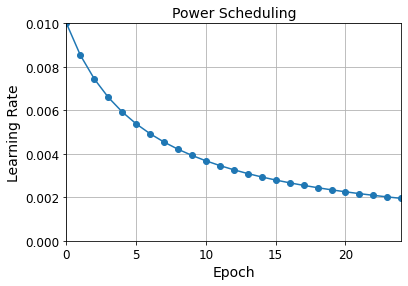

In [116]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

- 指数関数的スケジューリング

In [118]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [120]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

In [121]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [123]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [124]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [125]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8413 - accuracy: 0.7602 - val_loss: 0.9616 - val_accuracy: 0.7508
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6649 - accuracy: 0.8006 - val_loss: 0.5579 - val_accuracy: 0.8332
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6201 - accuracy: 0.8122 - val_loss: 0.7026 - val_accuracy: 0.8166
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5367 - accuracy: 0.8326 - val_loss: 0.5312 - val_accuracy: 0.8308
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5018 - accuracy: 0.8436 - val_loss: 0.5049 - val_accuracy: 0.8590
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4486 - accuracy: 0.8587 - val_loss: 0.4641 - val_accuracy: 0.8602
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4186 - accuracy: 0.8689 - val_loss: 0.5256 - val_accuracy:

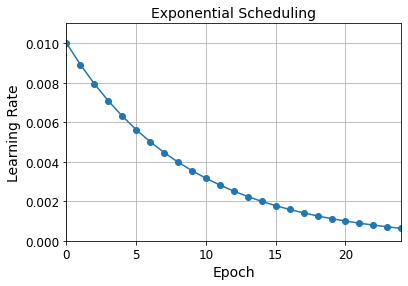

In [126]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [127]:
# 学習率を引数に取れる
# def exponential_decay_fn(epoch, lr):
#     return lr * 0.1**(1 / 20)

- epochでなくiteration毎に学習率をアップデートしたい場合はオリジナルのクラスを書く必要がある

In [128]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [129]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)

In [130]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [131]:
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8010 - accuracy: 0.7642 - val_loss: 0.8409 - val_accuracy: 0.7246
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6165 - accuracy: 0.8058 - val_loss: 0.5961 - val_accuracy: 0.8236
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5716 - accuracy: 0.8240 - val_loss: 0.6667 - val_accuracy: 0.8106
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5186 - accuracy: 0.8380 - val_loss: 0.4846 - val_accuracy: 0.8582
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4607 - accuracy: 0.8532 - val_loss: 0.4946 - val_accuracy: 0.8516
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4239 - accuracy: 0.8648 - val_loss: 0.4841 - val_accuracy: 0.8532
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4009 - accuracy: 0.8723 - val_loss: 0.4184 - val_accuracy:

In [132]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

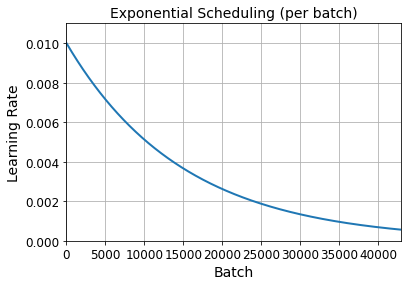

In [133]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

- Piecewise Constant Scheduling

In [134]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [135]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [136]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [137]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [138]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8584 - accuracy: 0.7530 - val_loss: 1.2704 - val_accuracy: 0.7192
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9002 - accuracy: 0.7329 - val_loss: 0.8066 - val_accuracy: 0.7092
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9038 - accuracy: 0.7190 - val_loss: 1.1419 - val_accuracy: 0.6816
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9279 - accuracy: 0.7127 - val_loss: 0.7587 - val_accuracy: 0.7256
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9287 - accuracy: 0.7100 - val_loss: 0.9749 - val_accuracy: 0.6702
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6688 - accuracy: 0.7664 - val_loss: 0.6283 - val_accuracy: 0.8198
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5762 - accuracy: 0.8216 - val_loss: 0.5664 - val_accuracy:

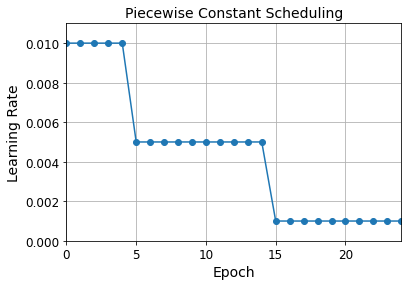

In [139]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

- Performance Scheduling

In [142]:
tf.random.set_seed(42)
np.random.seed(42)

In [143]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [145]:
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [146]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5920 - accuracy: 0.8061 - val_loss: 0.4696 - val_accuracy: 0.8566
Epoch 2/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4906 - accuracy: 0.8414 - val_loss: 0.6437 - val_accuracy: 0.8272
Epoch 3/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5199 - accuracy: 0.8397 - val_loss: 0.5292 - val_accuracy: 0.8530
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5118 - accuracy: 0.8476 - val_loss: 0.4798 - val_accuracy: 0.8558
Epoch 5/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5147 - accuracy: 0.8485 - val_loss: 0.6334 - val_accuracy: 0.8282
Epoch 6/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5063 - accuracy: 0.8551 - val_loss: 0.5126 - val_accuracy: 0.8588
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3060 - accuracy: 0.8934 - val_loss: 0.3886 - val_accuracy:

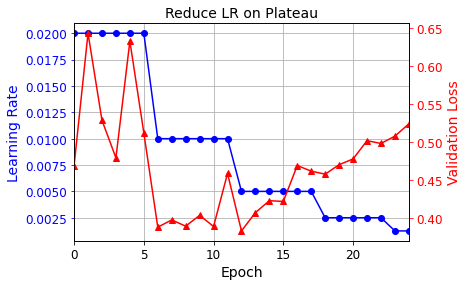

In [147]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

- tf.keras schedulers

In [148]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [149]:
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [150]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3820 - accuracy: 0.8650 - val_loss: 0.3739 - val_accuracy: 0.8690
Epoch 3/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3487 - accuracy: 0.8766 - val_loss: 0.3734 - val_accuracy: 0.8688
Epoch 4/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3264 - accuracy: 0.8836 - val_loss: 0.3494 - val_accuracy: 0.8800
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3104 - accuracy: 0.8898 - val_loss: 0.3431 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2957 - accuracy: 0.8955 - val_loss: 0.3416 - val_accuracy: 0.8808
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2853 - accuracy: 0.8987 - val_loss: 0.3354 - val_accuracy:

In [151]:
# For piecewise constant scheduling
# learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
#     values=[0.01, 0.005, 0.001])

- 1Cycle scheduling

In [152]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [153]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [154]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [159]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [155]:
tf.random.set_seed(42)
np.random.seed(42)

In [156]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [157]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3859


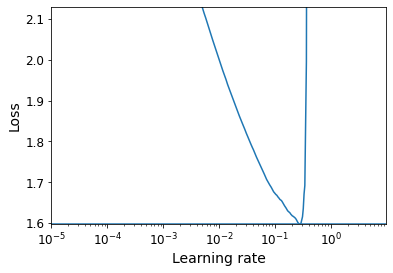

In [158]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [160]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4122 - accuracy: 0.8545 - val_loss: 0.4115 - val_accuracy: 0.8582
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.3869 - val_accuracy: 0.8688
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8718 - val_loss: 0.3766 - val_accuracy: 0.8682
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3457 - accuracy: 0.8775 - val_loss: 0.3744 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8809 - val_loss: 0.3635 - val_accuracy: 0.8704
Epoch 

# 11.4 正則化による過学習の防止

## 11.4.1 l1, l2正則化

In [161]:
from functools import partial

In [163]:
# partialで一纏めにする
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [164]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [165]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [166]:
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6223 - accuracy: 0.8109 - val_loss: 0.7201 - val_accuracy: 0.8306
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7204 - accuracy: 0.8269 - val_loss: 0.6843 - val_accuracy: 0.8368


## 11.4.2 ドロップアウト

In [167]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [168]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [169]:
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5597 - accuracy: 0.8059 - val_loss: 0.3672 - val_accuracy: 0.8654
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4230 - accuracy: 0.8453 - val_loss: 0.3476 - val_accuracy: 0.8686


- アルファドロップアウト
- 自己正規化を維持したい場合に使う

In [173]:
tf.random.set_seed(42)
np.random.seed(42)

In [170]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [171]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [172]:
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6651 - accuracy: 0.7577 - val_loss: 0.5784 - val_accuracy: 0.8464
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5549 - accuracy: 0.7952 - val_loss: 0.5794 - val_accuracy: 0.8480
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5254 - accuracy: 0.8062 - val_loss: 0.5038 - val_accuracy: 0.8568
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5078 - accuracy: 0.8110 - val_loss: 0.4738 - val_accuracy: 0.8582
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4927 - accuracy: 0.8178 - val_loss: 0.4469 - val_accuracy: 0.8612
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4825 - accuracy: 0.8217 - val_loss: 0.4533 - val_accuracy: 0.8664
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4760 - accuracy: 0.8238 - val_loss: 0.4736 - val_accuracy:

- 評価はドロップアウトなしで揃える

In [175]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 979us/step - loss: 0.3377 - accuracy: 0.8864


[0.33765965700149536, 0.8864181637763977]

In [176]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 950us/step - loss: 0.4536 - accuracy: 0.8662


[0.45360052585601807, 0.8661999702453613]

## 11.4.3 モンテカルロ（MC）ドロップアウト

In [177]:
tf.random.set_seed(42)
np.random.seed(42)

In [178]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [184]:
y_probas.shape

(100, 10000, 10)

- ドロップアウトとMCドロップアウトの予測結果の違いを確認する

In [185]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [187]:
np.round(y_probas[:, :1], 2)[:5]

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.76, 0.  , 0.24]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.83, 0.  , 0.17]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.04, 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.48, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.9 ]]],
      dtype=float32)

In [188]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.24, 0.  , 0.69]],
      dtype=float32)

In [189]:
# 推定確率の分散
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.26, 0.  , 0.3 ]],
      dtype=float32)

In [190]:
# 予測結果
y_pred = np.argmax(y_proba, axis=1)

accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8669

In [192]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [193]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [194]:
tf.random.set_seed(42)
np.random.seed(42)

In [195]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [196]:
mc_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_265 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_266 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_267 (Dense)            (None, 10)              

In [197]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [198]:
mc_model.set_weights(model.get_weights())

In [199]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.24, 0.  , 0.69]],
      dtype=float32)

# 11.6 演習問題

## 8-a.

In [265]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [266]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3])
])

for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

## 8-b.

In [267]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [268]:
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [269]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [270]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, "my_cifar10_model.h5"), save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(LOGS_PATH, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

2021-11-25 16:23:55.857384: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 16:23:55.857405: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 16:23:55.858048: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [271]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks,
                    verbose=0)

2021-11-25 16:24:15.344180: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 16:24:15.344198: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 16:24:15.466617: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-25 16:24:15.471344: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-25 16:24:15.475535: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/chapter_11/my_cifar10_logs/run_001/train/plugins/profile/2021_11_25_16_24_15

2021-11-25 16:24:15.478630: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/chapter_11/my_cifar10_logs/run_001/train/plugins/profile/2021_11_25_16_24_15/mochidzukiyoshihikonoMacBook-Pro.local.trace.json.gz
2021-11-25 16:24:15.491209: I tensorflow/core/profiler/rpc/client/save_profile.cc:13

In [272]:
model = keras.models.load_model(os.path.join(MODELS_PATH, "my_cifar10_model.h5"))
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5433 - accuracy: 0.4518


[1.5432615280151367, 0.45179998874664307]

## 8-c.

In [273]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [274]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [275]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [278]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, "my_cifar10_bn_model.h5"), save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(LOGS_PATH, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

2021-11-25 16:31:26.512071: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 16:31:26.512093: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 16:31:26.512380: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [279]:
model.fit(X_train, y_train, epochs=20,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks,
          verbose=0)

2021-11-25 16:32:17.386361: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 16:32:17.386379: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 16:32:17.839296: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-25 16:32:17.853311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-25 16:32:17.866100: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./models/chapter_11/my_cifar10_logs/run_bn_001/train/plugins/profile/2021_11_25_16_32_17

2021-11-25 16:32:17.873216: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./models/chapter_11/my_cifar10_logs/run_bn_001/train/plugins/profile/2021_11_25_16_32_17/mochidzukiyoshihikonoMacBook-Pro.local.trace.json.gz
2021-11-25 16:32:17.902241: I tensorflow/core/profiler/rpc/client/save_pro

In [280]:
model = keras.models.load_model(os.path.join(MODELS_PATH, "my_cifar10_bn_model.h5"))
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 2ms/step - loss: 1.3306 - accuracy: 0.5394


[1.3306374549865723, 0.5393999814987183]

## 8-d

In [281]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [282]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [283]:
optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [284]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, "my_cifar10_selu_model.h5"), save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(LOGS_PATH, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

2021-11-25 16:51:07.301903: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 16:51:07.301932: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 16:51:07.302469: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [285]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [289]:
model.fit(X_train_scaled, y_train, epochs=20,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks,
          verbose=0)

2021-11-25 16:54:02.086917: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 16:54:02.086934: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 16:54:02.301505: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-25 16:54:02.310227: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-25 16:54:02.314995: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/chapter_11/my_cifar10_logs/run_selu_003/train/plugins/profile/2021_11_25_16_54_02

2021-11-25 16:54:02.320207: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/chapter_11/my_cifar10_logs/run_selu_003/train/plugins/profile/2021_11_25_16_54_02/mochidzukiyoshihikonoMacBook-Pro.local.trace.json.gz
2021-11-25 16:54:02.335726: I tensorflow/core/profiler/rpc/client/save_pro

In [290]:
model = keras.models.load_model(os.path.join(MODELS_PATH, "my_cifar10_selu_model.h5"))
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.4471 - accuracy: 0.5068


[1.4470531940460205, 0.5067999958992004]

## 8-e

In [291]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [292]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

In [293]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [294]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, "my_cifar10_alpha_dropout_model.h5"), save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(LOGS_PATH, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

2021-11-25 17:15:24.986307: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 17:15:24.986329: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 17:15:24.987073: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [295]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [296]:
model.fit(X_train_scaled, y_train, epochs=20,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/20
   2/1407 [..............................] - ETA: 1:38 - loss: 3.0759 - accuracy: 0.1094   

2021-11-25 17:16:19.067189: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-25 17:16:19.067205: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-25 17:16:19.236355: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-25 17:16:19.246137: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-25 17:16:19.250822: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/chapter_11/my_cifar10_logs/run_alpha_dropout_004/train/plugins/profile/2021_11_25_17_16_19

2021-11-25 17:16:19.253987: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/chapter_11/my_cifar10_logs/run_alpha_dropout_004/train/plugins/profile/2021_11_25_17_16_19/mochidzukiyoshihikonoMacBook-Pro.local.trace.json.gz
2021-11-25 17:16:19.267610: I tensorflow/core/profiler/r

  33/1407 [..............................] - ETA: 18s - loss: 2.4641 - accuracy: 0.1818

2021-11-25 17:16:19.268029: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/chapter_11/my_cifar10_logs/run_alpha_dropout_004/train/plugins/profile/2021_11_25_17_16_19/mochidzukiyoshihikonoMacBook-Pro.local.memory_profile.json.gz
2021-11-25 17:16:19.270308: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/chapter_11/my_cifar10_logs/run_alpha_dropout_004/train/plugins/profile/2021_11_25_17_16_19
Dumped tool data for xplane.pb to ./logs/chapter_11/my_cifar10_logs/run_alpha_dropout_004/train/plugins/profile/2021_11_25_17_16_19/mochidzukiyoshihikonoMacBook-Pro.local.xplane.pb
Dumped tool data for overview_page.pb to ./logs/chapter_11/my_cifar10_logs/run_alpha_dropout_004/train/plugins/profile/2021_11_25_17_16_19/mochidzukiyoshihikonoMacBook-Pro.local.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/chapter_11/my_cifar10_logs/run_alpha_dropout_004/train/plugins/pr

1407/1407 [==============================] - 12s 6ms/step - loss: 1.8849 - accuracy: 0.3307 - val_loss: 1.7560 - val_accuracy: 0.3858
Epoch 2/20
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6648 - accuracy: 0.4142 - val_loss: 1.6932 - val_accuracy: 0.4066
Epoch 3/20
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5757 - accuracy: 0.4460 - val_loss: 1.6404 - val_accuracy: 0.4224
Epoch 4/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5097 - accuracy: 0.4699 - val_loss: 1.5988 - val_accuracy: 0.4582
Epoch 5/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4510 - accuracy: 0.4947 - val_loss: 1.5834 - val_accuracy: 0.4616
Epoch 6/20
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4059 - accuracy: 0.5116 - val_loss: 1.5627 - val_accuracy: 0.4722
Epoch 7/20
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3629 - accuracy: 0.5255 - val_loss: 1.5140 - val_accuracy: 0.4864
Ep

In [297]:
model = keras.models.load_model(os.path.join(MODELS_PATH, "my_cifar10_alpha_dropout_model.h5"))
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.4828 - accuracy: 0.4972


[1.4828402996063232, 0.49720001220703125]

In [298]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [299]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [302]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [303]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4962

## 8-f

In [304]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [305]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

In [306]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 6ms/step - loss: nan - accuracy: 0.1376


(9.999999747378752e-06,
 9.615227699279785,
 2.625960111618042,
 3.942016022545951)

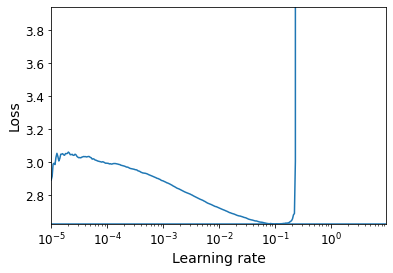

In [307]:
atch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [308]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [309]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

In [310]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [311]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle],
                    verbose=0)